In [ ]:
# https://www.kaggle.com/crowdflower/twitter-airline-sentiment
!wget -nc https://lazyprogrammer.me/course_files/AirlineTweets.csv




File ‘AirlineTweets.csv’ already there; not retrieving.



In [ ]:
!pip install transformers

In [ ]:
from transformers import pipeline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix

In [ ]:
import torch #Get GPU Device

In [ ]:
torch.cuda.is_available() #whether or not cuda is available

True

In [ ]:
torch.cuda.current_device() #Current GPU/CUDA device

0

In [ ]:
#Use the GPU
classifier = pipeline("sentiment-analysis", device=0) # specified device corresponding to the new established GPU

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [ ]:
df = pd.read_csv("AirlineTweets.csv")
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)




1.   **"df = df[["airline_sentiment", "text"]].copy()"** -> **creates a new DataFrame** by **selecting only the columns "airline_sentiment" and "text"** from the existing DataFrame df.

2.   The **"copy()"** method is used to **create a deep copy of the selected DataFrame**. This **ensures** that **any changes made to the new DataFrame do not affect the original DataFrame.**



<Axes: >

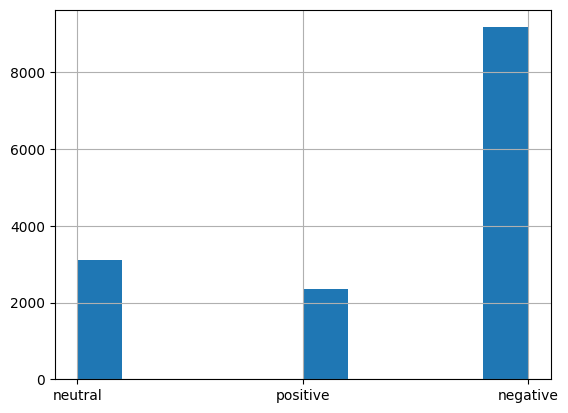

In [ ]:
#We only need the "airline_sentiment" & "text" columns for classification task
df = df[["airline_sentiment", "text"]].copy()
df['airline_sentiment'].hist() # to check whether our dataset contains class imbalance

 **The histogram show that the dataset has more "negative" comments compared to "neutral" and "positive" comments. Hence, class imbalance is present in the dataset.**

In [ ]:
df = df[df["airline_sentiment"] != "neutral"].copy()




>* **df["airline_sentiment"] != "neutral"** -> creates **a boolean mask** that **checks each value in the "airline_sentiment" column** and **returns a Series of boolean values (True or False),** where True indicates that the value is not "neutral" and False indicates that it is "neutral".







***Hugging Face transformer Pipeline that we're using only can classify "POSITIVE" & "NEGATIVE" texts. So, we must filter all "neutral" comments out of the dataframe "df" with which we're working with.***

In [ ]:
# map labels to integers
target_map = {"negative": 0, "positive": 1}
df["target"] = df["airline_sentiment"].map(target_map) #new column "target" add hoise , which contains '0' for negative & '1' for positive
df.head()

,airline_sentiment,text,target
1,positive,@VirginAmerica plus you've added commercials t...,1
3,negative,@VirginAmerica it's really aggressive to blast...,0
4,negative,@VirginAmerica and it's a really big bad thing...,0
5,negative,@VirginAmerica seriously would pay $30 a fligh...,0
6,positive,"@VirginAmerica yes, nearly every time I fly VX...",1


In [ ]:
texts = df["text"].tolist() #convert to list
predictions = classifier(texts)
texts[:10]

["@VirginAmerica plus you've added commercials to the experience... tacky.",
 '@VirginAmerica it\'s really aggressive to blast obnoxious "entertainment" in your guests\' faces &amp; they have little recourse',
 "@VirginAmerica and it's a really big bad thing about it",
 "@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying VA",
 '@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)',
 "@virginamerica Well, I didn't…but NOW I DO! :-D",
 "@VirginAmerica it was amazing, and arrived an hour early. You're too good to me.",
 '@VirginAmerica I &lt;3 pretty graphics. so much better than minimal iconography. :D',
 "@VirginAmerica This is such a great deal! Already thinking about my 2nd trip to @Australia &amp; I haven't even gone on my 1st trip yet! ;p",
 "@VirginAmerica @virginmedia I'm flying your #fabulous #Seductive skies again! U take all the #stress away from travel http://t.co/ahlX

In [ ]:
predictions

[{'label': 'POSITIVE', 'score': 0.6070840954780579},
 {'label': 'NEGATIVE', 'score': 0.9973449110984802},
 {'label': 'NEGATIVE', 'score': 0.9995823502540588},
 {'label': 'NEGATIVE', 'score': 0.9854250550270081},
 {'label': 'POSITIVE', 'score': 0.9553212523460388},
 {'label': 'POSITIVE', 'score': 0.9827088117599487},
 {'label': 'POSITIVE', 'score': 0.9994851350784302},
 {'label': 'POSITIVE', 'score': 0.9993509650230408},
 {'label': 'POSITIVE', 'score': 0.9940821528434753},
 {'label': 'POSITIVE', 'score': 0.9863133430480957},
 {'label': 'POSITIVE', 'score': 0.9996304512023926},
 {'label': 'NEGATIVE', 'score': 0.9980512857437134},
 {'label': 'POSITIVE', 'score': 0.9964436888694763},
 {'label': 'NEGATIVE', 'score': 0.9968666434288025},
 {'label': 'POSITIVE', 'score': 0.9787647724151611},
 {'label': 'POSITIVE', 'score': 0.9995218515396118},
 {'label': 'NEGATIVE', 'score': 0.9954516291618347},
 {'label': 'POSITIVE', 'score': 0.9995624423027039},
 {'label': 'POSITIVE', 'score': 0.999874830245

All probabilities must be of the probalbilty of same target class. <br>
For example,
<pre>
{'label': 'POSITIVE', 'score': 0.9838072061538696}
</pre>
This indicates the **probability for P( y= 'POSITIVE'| x )**
<pre>
{'label': 'NEGATIVE', 'score': 0.9979093670845032}</pre>
This indicates the **probability for P( y= 'NEGATIVE'| x )**

We Need to have all probability in the same format as "POSITIVE" or 'NEGATIVE' probability. <br>
for that we calculate , **P( y= 'POSITIVE'| x ) = 1 - P( y= 'NEGATIVE'| x )**



In [ ]:
probs = [d['score'] if d['label'].startswith('P') else 1-d['score'] for d in predictions]

In [ ]:
probs # we need probabilities to compute metrics like AUC

[0.6070840954780579,
 0.0026550889015197754,
 0.0004176497459411621,
 0.014574944972991943,
 0.9553212523460388,
 0.9827088117599487,
 0.9994851350784302,
 0.9993509650230408,
 0.9940821528434753,
 0.9863133430480957,
 0.9996304512023926,
 0.001948714256286621,
 0.9964436888694763,
 0.0031333565711975098,
 0.9787647724151611,
 0.9995218515396118,
 0.004548370838165283,
 0.9995624423027039,
 0.9998748302459717,
 0.004880666732788086,
 0.00040477514266967773,
 0.0006322264671325684,
 0.015428304672241211,
 0.01828092336654663,
 0.0004482865333557129,
 0.0023748278617858887,
 0.9934480786323547,
 0.9976067543029785,
 0.8661719560623169,
 0.0003237724304199219,
 0.8415618538856506,
 0.0032317638397216797,
 0.9997846484184265,
 0.1761431097984314,
 0.9993895292282104,
 0.09156662225723267,
 0.004861712455749512,
 0.9997820258140564,
 0.0014235973358154297,
 0.004673957824707031,
 0.00464242696762085,
 0.019041001796722412,
 0.991169810295105,
 0.0125504732131958,
 0.00809931755065918,
 0.99

In [ ]:
#list of predicted class; '0' for negative & '1' for positive
pred = [1 if d['label'].startswith('P') else 0 for d in predictions]  # pred = [1,1,0,0,0,1,1,1,1,1,1,1,1,1,.....]

In [ ]:
pred = np.array(pred) #convert to numpy array

# <u>Syntax </u>: <br> confusion_matrix( y_actualValue , y_predictedValue )
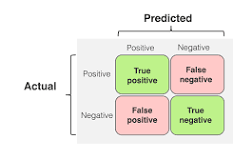

In [ ]:
cm = confusion_matrix(df["target"], pred, normalize="true") # normalize="true" -> so that each row sums to 1
cm

array([[0.90117673, 0.09882327],
       [0.15404147, 0.84595853]])

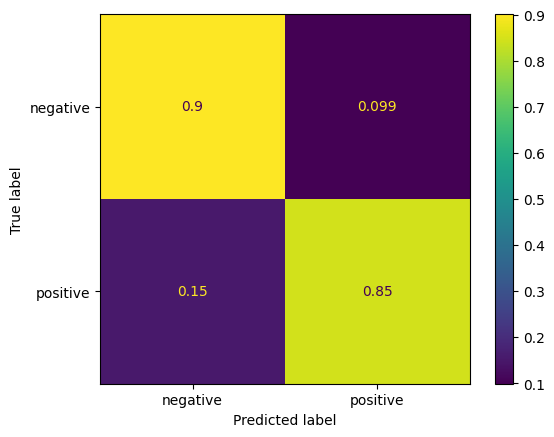

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_map.keys())
disp.plot()
plt.show()

#Calculating Accuracy using mean
- **"pred == df['target']"** generates **a boolean array** where each element is **True** if **the predicted label matches the actual label**, and False otherwise.
- **"np.mean(pred == df['target'])"** calculates the mean of this boolean array. In Python, True is treated as 1 and False as 0.


> For example, if **pred** is **[1, 0, 1, 1, 0]** and **df['target']** is **[1, 0, 0, 1, 0]**, the comparison **pred == train_labels** yields **[True, True, False, True, True]**, which is **[1, 1, 0, 1, 1] in numeric form**. The **mean of this array** is **(1 + 1 + 0 + 1 + 1) / 5 = 4 / 5 = 0.8**, indicating **80% accuracy.**



In [ ]:
print("Accuracy: ", np.mean(pred == df["target"]))

Accuracy:  0.8898708950697514


**Since the dataset is class imbalanced, the accuracy could be misleading.**

In [ ]:
print("AUC Score:",roc_auc_score(df["target"], probs))
print("AUC Score After Inverting Labels:",roc_auc_score(1-df["target"], 1-np.array(probs))) # since AUC score doesn't rely on label assignment,will produce same AUC_Scores


AUC Score: 0.9485934690648773
AUC Score After Inverting Labels: 0.9485934690648772


# F1 - Score

**F1- score focuses on the ratio of TRUE POSITIVEs. What we can derive from that is , F1-score rely on what label is actual assigned as Positive and what is Assigned as Negative.  Its the Harmonic Mean of Precision and Recall. Hence, it is not symmetric.**

In [ ]:

print("F1-Score:",f1_score(df["target"], pred))
print("F1-Score After Inverting Labels:",f1_score(1-df["target"], 1-pred)) # inverting the values (0 to 1 and vice-versa); produce different f1-scores

F1-Score: 0.7587777566900741
F1-Score After Inverting Labels: 0.928647616908999
